<a href="https://colab.research.google.com/github/johanhoffman/DD2365_VT24/blob/jengstrandj_lab2/Lab2/jengstrandj_lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The Navier-Stokes equations**
**Template by Johan Hoffman**

Edited by Josefin Engstrand Jonsson

# **Abstract**

In this report, we implement a stabilized finite element method in FEniCS to solve the 2D Navier-Stokes equations for flow past a circular obstacle. We study the effect of increasing the Reynolds number as well as decreasing the mesh resolution. We also compute the drag and lift coefficients, along with the Strouhal number if vortex shedding occurs. The resulting velocity and pressure fields are visualized in the form of snapshots in time but also as Paraview animations.

# **About the code**

In [ ]:
"""This program is an example file for the course"""

"""DD2365 Advanced Computation in Fluid Mechanics, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2020 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

# **Set up environment**

In [ ]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

# Install FEniCS (this may take a long time)
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

# **Introduction**

The Navier-Stokes equations take the form

$\dot u + (u\cdot \nabla)u + \nabla p -\Delta u = f,\quad \nabla \cdot u=0,$

together with suitable initial and boundary conditions. We seek a finite element approximation $(u,p)\in V\times Q$ such that

$(\dot u + (u\cdot \nabla)u, v) - (p,\nabla \cdot v) + (\nu \nabla u,\nabla v) + (\nabla \cdot u, q) + SD(u,p;v,q) = (f,v),$

for all test functions $(v,q) \in \hat V\times \hat Q$, where $SD(u,p;v,q)$ is a residual based stabilization term.

We present an example of flow past a circular cylinder. We compute the force on the cylinder surface $\Gamma$ in the direction $\phi$ by Green's formula:

$F(u,p,\phi)= \left<\nu \nabla u\cdot n-pn, \Phi\right>_{\Gamma} =(\dot u+(u\cdot \nabla)u, \Phi) + (\nu \nabla u,\nabla \Phi) - (p,\nabla \cdot\Phi)-(f,\Phi),$

with $\Phi\in V$ a function for which $\Phi\vert _{\Gamma}=\phi$ and $\Phi\vert_{\partial \Omega \setminus \Gamma}=0$. With $\phi=(1,0)$ we get the drag force $F_D$, and with $\phi=(0,1)$ the lift force $F_L$. The drag and lift coefficients are obtained by normalization,

$c_D = \frac{2F_D}{\rho U^2D}, \quad c_L = \frac{2F_L}{\rho U^2D},$

where $\rho$ is the density, $U$ the characteristic velocity, and $D$ the characteristic length scale. Here, $U=1$ is the inflow velocity and $D=0.4$ is the diameter of the cylinder, and the density is taken to be $\rho=1$. The Strouhal number is given as

$St = \frac{fD}{U}$,

where $f$ is the frequency of vortex shedding. Finally, the Reynolds number is defined as

$Re=\frac{UD}{\nu}$.


# **Method**

**Define domain and mesh**

Our computational domain is a rectangular channel of size 4x2, with a circular hole of radius 0.2 centered at $(x, y) = (1, 1)$. Three different mesh resolutions will be used throughout this report: $h=1/32, 1/16$ and $1/8$.

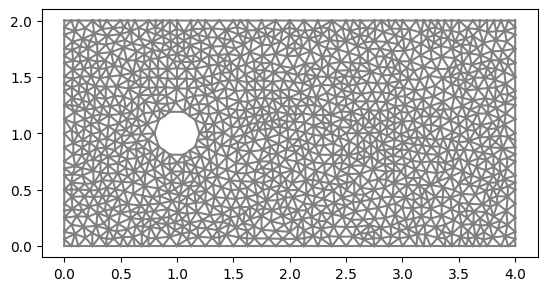

In [ ]:
# Define rectangular domain
L = 4
H = 2

# Define circle
xc = 1.0
yc = 0.5 * H
rc = 0.2


# Define subdomains (for boundary conditions)
class Left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 0.0)


class Right(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], L)


class Lower(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0.0)


class Upper(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], H)


left = Left()
right = Right()
lower = Lower()
upper = Upper()

# Generate a mesh with a hole
resolution = 32
# resolution = 16
# resolution = 8
mesh = generate_mesh(
    Rectangle(Point(0.0, 0.0), Point(L, H)) - Circle(Point(xc, yc), rc), resolution
)

# Local mesh refinement (specified by a cell marker)
no_levels = 0
for i in range(0, no_levels):
    cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
    for cell in cells(mesh):
        cell_marker[cell] = False
        p = cell.midpoint()
        if p.distance(Point(xc, yc)) < 1.0:
            cell_marker[cell] = True
    mesh = refine(mesh, cell_marker)

# Define mesh functions (for boundary conditions)
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
boundaries.set_all(0)
left.mark(boundaries, 1)
right.mark(boundaries, 2)
lower.mark(boundaries, 3)
upper.mark(boundaries, 4)

plt.figure()
plot(mesh)
plt.show()

**Define finite element approximation spaces**

We use continuous piecewise linear approximations of the velocity and the pressure.

In [ ]:
# Generate finite element spaces (for velocity and pressure)
V = VectorFunctionSpace(mesh, "Lagrange", 1)
Q = FunctionSpace(mesh, "Lagrange", 1)

# Define trial and test functions
u = TrialFunction(V)
p = TrialFunction(Q)
v = TestFunction(V)
q = TestFunction(Q)

**Define boundary conditions**

The boundary conditions are of the Dirichlet type, with the velocity equal to 1 at inflow, else 0. The pressure is 0 at outflow.

In [ ]:
# Define boundary conditions
class DirichletBoundaryLower(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], 0.0)


class DirichletBoundaryUpper(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], H)


class DirichletBoundaryLeft(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0.0)


class DirichletBoundaryRight(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], L)


class DirichletBoundaryObjects(SubDomain):
    def inside(self, x, on_boundary):
        return (
            on_boundary
            and (not near(x[0], 0.0))
            and (not near(x[0], L))
            and (not near(x[1], 0.0))
            and (not near(x[1], H))
        )


dbc_lower = DirichletBoundaryLower()
dbc_upper = DirichletBoundaryUpper()
dbc_left = DirichletBoundaryLeft()
dbc_right = DirichletBoundaryRight()
dbc_objects = DirichletBoundaryObjects()

# Stationary inflow conditions for velocity
uin = 1.0
bcu_in0 = DirichletBC(V.sub(0), uin, dbc_left)
bcu_in1 = DirichletBC(V.sub(1), 0.0, dbc_left)
bcu_upp0 = DirichletBC(V.sub(0), 0.0, dbc_upper)
bcu_upp1 = DirichletBC(V.sub(1), 0.0, dbc_upper)
bcu_low0 = DirichletBC(V.sub(0), 0.0, dbc_lower)
bcu_low1 = DirichletBC(V.sub(1), 0.0, dbc_lower)
bcu_obj0 = DirichletBC(V.sub(0), 0.0, dbc_objects)
bcu_obj1 = DirichletBC(V.sub(1), 0.0, dbc_objects)

pout = 0.0
bcp1 = DirichletBC(Q, pout, dbc_right)

# bcu = [bcu_in0, bcu_in1, bcu_upp0, bcu_upp1, bcu_low0, bcu_low1, bcu_obj0, bcu_obj1]
bcu = [bcu_in0, bcu_in1, bcu_upp1, bcu_low1, bcu_obj0, bcu_obj1]
bcp = [bcp1]

# Define measure for boundary integration
ds = Measure("ds", domain=mesh, subdomain_data=boundaries)

# **Results**

**Define flow parameters**

We can modify the Reynolds number for the problem by changing the viscosity. Recall that $Re=UD/\nu=0.4/\nu$. We will study four different Reynolds numbers: $Re=1, 10, 100$ and $1000$, corresponding to $\nu=0.4, 0.04, 0.004$ and $0.0004.$

In [ ]:
# Set viscosity
# nu = 4.0e-4  # Re = 1000
nu = 4.0e-3  # Re = 100
# nu = 4.0e-2  # Re = 10
# nu = 4.0e-1  # Re = 1

# Compute Reynolds number
Re = uin * 2 * rc / nu
print(Re)

**Define method parameters**

In [ ]:
# Define iteration functions
# (u0,p0) solution from previous time step
# (u1,p1) linearized solution at present time step
u0 = Function(V)
u1 = Function(V)
p0 = Function(Q)
p1 = Function(Q)

# Set parameters for nonlinear and linear solvers
num_nnlin_iter = 5
prec = "amg" if has_krylov_solver_preconditioner("amg") else "default"

# Time step length
dt = 0.5 * mesh.hmin()

**Define variational problem**

In [ ]:
# Stabilization parameters
h = CellDiameter(mesh)
u_mag = sqrt(dot(u1, u1))
d1 = 1.0 / sqrt((pow(1.0 / dt, 2.0) + pow(u_mag / h, 2.0)))
d2 = h * u_mag

# Mean velocities for trapozoidal time stepping
um = 0.5 * (u + u0)
um1 = 0.5 * (u1 + u0)

# Momentum variational equation on residual form
Fu = (
    inner((u - u0) / dt + grad(um) * um1, v) * dx
    - p1 * div(v) * dx
    + nu * inner(grad(um), grad(v)) * dx
    + d1 * inner((u - u0) / dt + grad(um) * um1 + grad(p1), grad(v) * um1) * dx
    + d2 * div(um) * div(v) * dx
)
au = lhs(Fu)
Lu = rhs(Fu)

# Continuity variational equation on residual form
Fp = (
    d1 * inner((u1 - u0) / dt + grad(um1) * um1 + grad(p), grad(q)) * dx
    + div(um1) * q * dx
)
ap = lhs(Fp)
Lp = rhs(Fp)

**Compute force on boundary**

As mentioned in the introduction, to compute the drag force, we take $\phi=(1, 0)$.

In [ ]:
# Define the direction of the drag force
phi_x = 1.0
phi_y = 0.0

psi_expression = Expression(
    (
        "near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_x : 0.",
        "near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_y : 0.",
    ),
    xc=xc,
    yc=yc,
    rc=rc,
    phi_x=phi_x,
    phi_y=phi_y,
    element=V.ufl_element(),
)
psi = interpolate(psi_expression, V)
drag_force = (
    inner((u1 - u0) / dt + grad(um1) * um1, psi) * dx
    - p1 * div(psi) * dx
    + nu * inner(grad(um1), grad(psi)) * dx
)

# Force normalization
D = 2 * rc
normalization = -2.0 / D

To get the lift force, we instead take $\phi=(0, 1)$.

In [ ]:
# Define the direction of the lift force
phi_x = 0.0
phi_y = 1.0

psi_expression = Expression(
    (
        "near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_x : 0.",
        "near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_y : 0.",
    ),
    xc=xc,
    yc=yc,
    rc=rc,
    phi_x=phi_x,
    phi_y=phi_y,
    element=V.ufl_element(),
)
psi = interpolate(psi_expression, V)
lift_force = (
    inner((u1 - u0) / dt + grad(um1) * um1, psi) * dx
    - p1 * div(psi) * dx
    + nu * inner(grad(um1), grad(psi)) * dx
)

**Set plotting variables and open export files**

In [ ]:
# Open files to export solution to Paraview
file_u = File("results-NS/u.pvd")
file_p = File("results-NS/p.pvd")

# Set plot frequency
plot_time = 15
plot_freq = 5

# Force computation data
lift_force_array = np.array(0.0)
lift_force_array = np.delete(lift_force_array, 0)
drag_force_array = np.array(0.0)
drag_force_array = np.delete(drag_force_array, 0)
time = np.array(0.0)
time = np.delete(time, 0)
start_sample_time = 1.0

**Time stepping algorithm**

In [ ]:
!rm results-NS/*

# Time stepping
T = 30
t = dt

while t < T + DOLFIN_EPS:
    # Solve non-linear problem
    k = 0
    while k < num_nnlin_iter:
        # Assemble momentum matrix and vector
        Au = assemble(au)
        bu = assemble(Lu)

        # Compute velocity solution
        [bc.apply(Au, bu) for bc in bcu]
        [bc.apply(u1.vector()) for bc in bcu]
        solve(Au, u1.vector(), bu, "bicgstab", "default")

        # Assemble continuity matrix and vector
        Ap = assemble(ap)
        bp = assemble(Lp)

        # Compute pressure solution
        [bc.apply(Ap, bp) for bc in bcp]
        [bc.apply(p1.vector()) for bc in bcp]
        solve(Ap, p1.vector(), bp, "bicgstab", prec)

        # Compute lift force
        F_lift = assemble(lift_force)
        if (t > start_sample_time):
          lift_force_array = np.append(lift_force_array, normalization*F_lift)
          time = np.append(time, t)

        # Compute drag force
        F_drag = assemble(drag_force)
        if (t > start_sample_time):
          drag_force_array = np.append(drag_force_array, normalization*F_drag)

        k += 1

    if t >= plot_time:
        s = 'Time t = ' + repr(t)
        print(s)

        # Save solution to file
        file_u << u1
        file_p << p1

        # Plot solution
        plt.figure()
        plot(u1, title=f"Velocity, resolution={resolution}, Re={int(Re)}, t={round(t, 2)}")
        plt.savefig(f"Velocity,resolution={resolution},Re={int(Re)},t={round(t, 2)}.png")
        plt.show()

        plt.figure()
        plot(p1, title=f"Pressure, resolution={resolution}, Re={int(Re)}, t={round(t, 2)}")
        plt.savefig(f"Pressure,resolution={resolution},Re={int(Re)},t={round(t, 2)}.png")
        plt.show()

        plt.figure()
        plt.title(f"Lift force, resolution={resolution}, Re={int(Re)}, t={round(t, 2)}")
        plt.plot(time, lift_force_array)
        plt.savefig(f"Liftforce,resolution={resolution},Re={int(Re)},t={round(t, 2)}.png")
        plt.show()

        plt.figure()
        plt.title(f"Drag force, resolution={resolution}, Re={int(Re)}, t={round(t, 2)}")
        plt.plot(time, drag_force_array)
        plt.savefig(f"Dragforce,resolution={resolution},Re={int(Re)},t={round(t, 2)}.png")
        plt.show()

        plot_time += T/plot_freq

    # Update time step
    u0.assign(u1)
    t += dt

!tar -czvf results-NS.tar.gz results-NS
files.download('results-NS.tar.gz')

**Compute drag and lift coefficients**

Since $\rho=1$, $U=1$ and $D=0.4$, the drag and lift coefficients are given by $c_D = F_D/0.2$ and $c_L = F_L/0.2$. If the flow is unstable, then the forces (and, by extension, $c_D$ and $c_L$) will oscillate. We therefore compute the mean values of $c_D$ and $c_L$ as well as their corresponding standard deviations. We only take into account the last 50 % of the force measurements to ensure the forces have either stabilized properly (for stable flow) or follow a proper oscillatory motion (for unstable flow).

In [ ]:
# Select the last half of the force measurements
lift_force_half = lift_force_array[len(lift_force_array) // 2 :]
drag_force_half = drag_force_array[len(drag_force_array) // 2 :]

# Compute the mean lift and drag coefficients
lift_coeff_mean = np.mean(lift_force_half / rc)
drag_coeff_mean = np.mean(drag_force_half / rc)

# Compute corresponding standard deviations
lift_coeff_std = np.std(lift_force_half / rc)
drag_coeff_std = np.std(drag_force_half / rc)

print(f"c_L = {round(lift_coeff_mean, 3)} pm {round(lift_coeff_std, 3)}")
print(f"c_D = {round(drag_coeff_mean, 3)} pm {round(drag_coeff_std, 3)}")

**Compute the Strouhal number**

We estimate the vortex shedding frequency $f$ by manually counting the number of cycles the forces complete during a chosen time interval. The Strouhal number can then be computed as $St = 0.4f$, since $U=1$ and $D=0.4$.

**Solution plots and the drag coefficients, lift coefficients and Strouhal numbers for different Reynolds numbers**

The velocity and pressure fields for $Re=1$ are shown below. The flow is stable and symmetric. The drag and lift forces remain constant over time, except for a brief period of oscillations at the beginning. We find that $c_D = 88.579$ and $c_L = 0.189$.

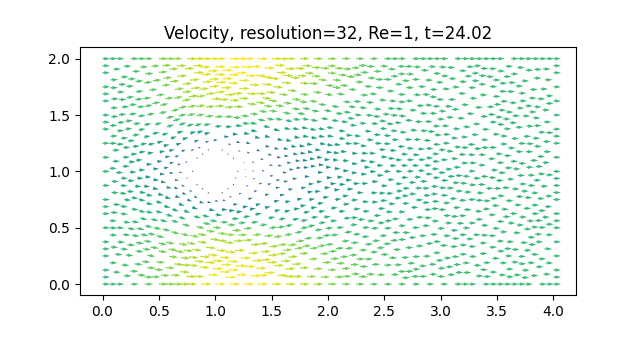

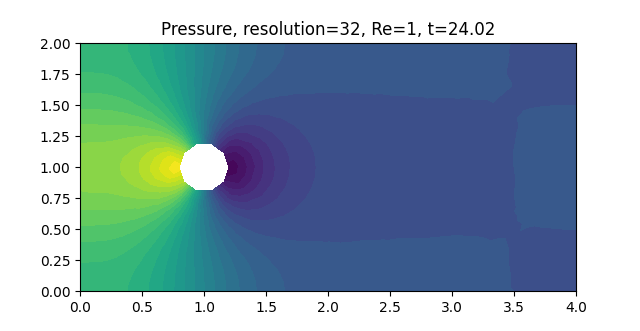

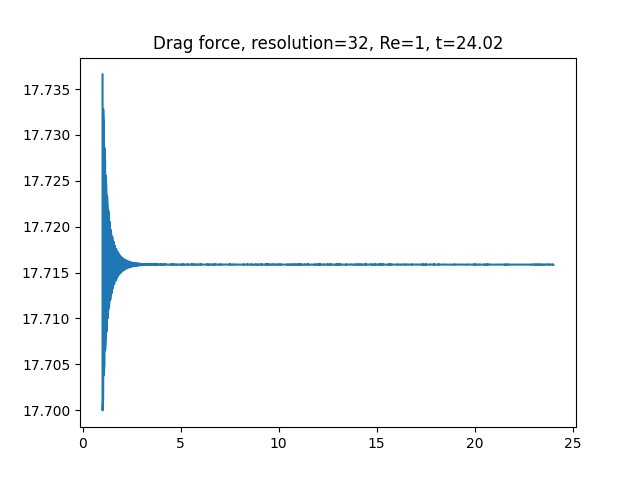

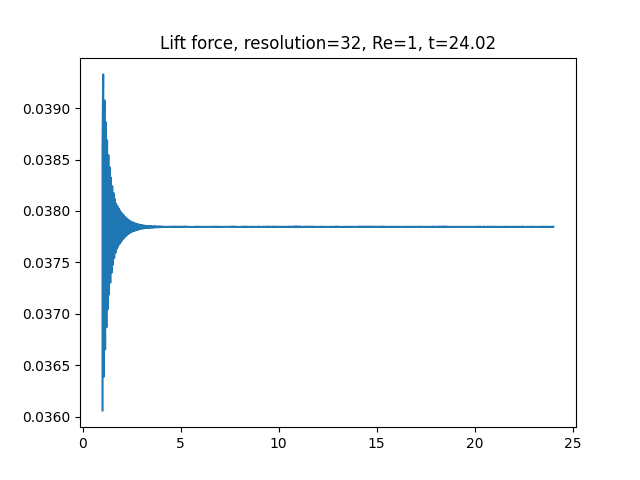

The solution remains stable when increasing the Reynolds number to $Re=10$, as shown in the following plots. Following some initial irregularities, the drag and lift forces stabilize and remain constant over time. This time, we have $c_D = 18.029$ and $c_L = 0.263$.  

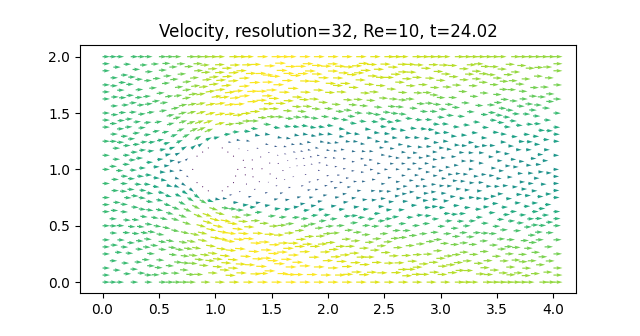

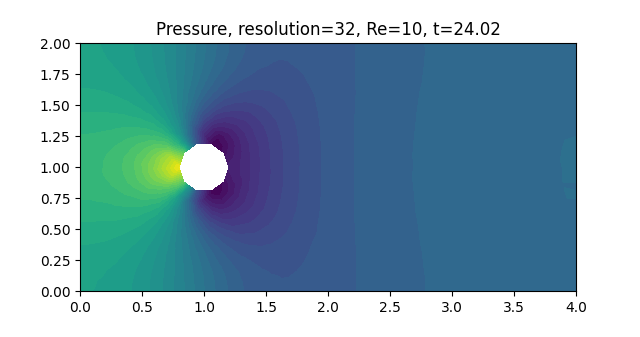

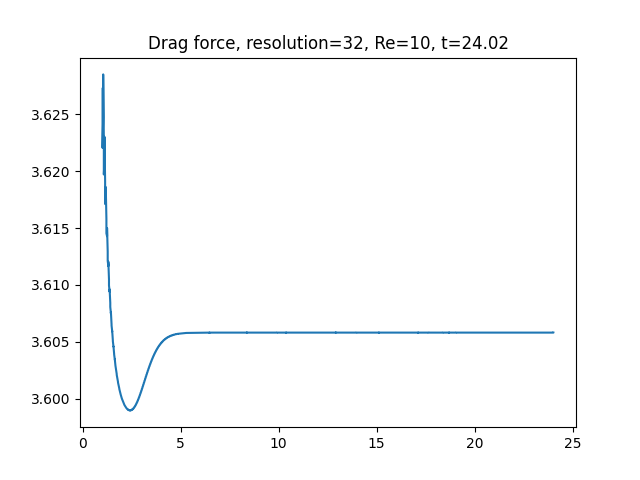

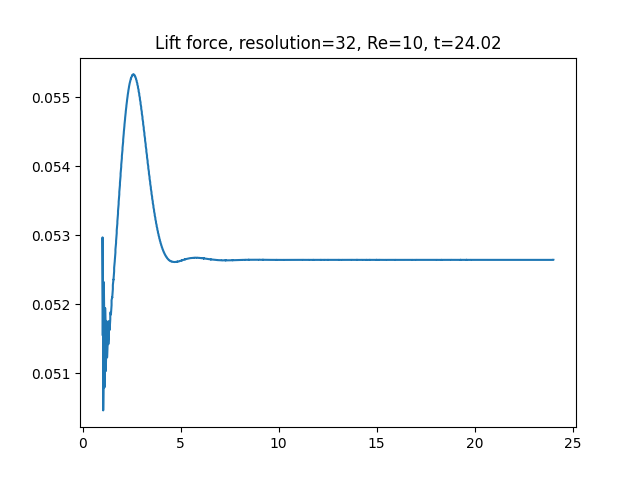

For $Re=100$, we obtain the plots below. A Karman vortex steet now forms behind the cylinder, indicating unstable flow. Additionally, the drag and lift forces oscillate. We estimate that there are roughly 5 oscillations per 10 time units, so that $f=0.5$. This gives $St=0.2$. We also determine that $c_{D}=8.596\pm0.143$ and $c_{L}=0.146\pm1.389$.

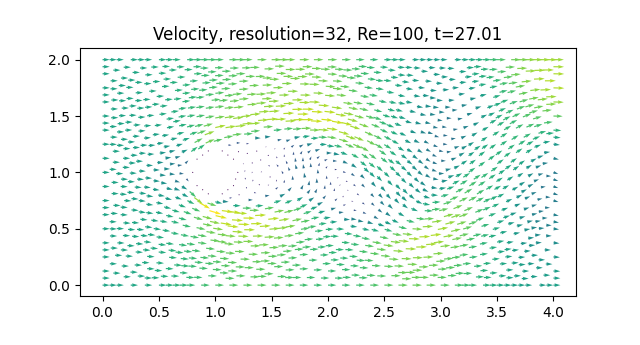

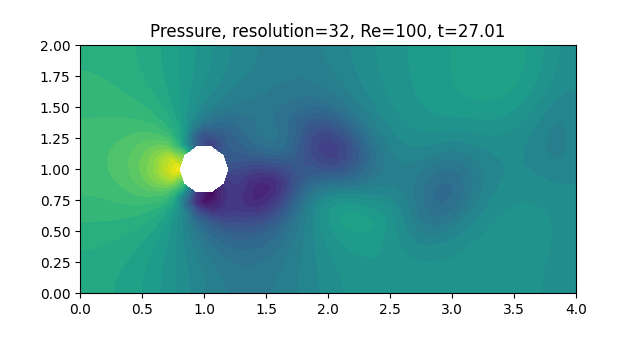

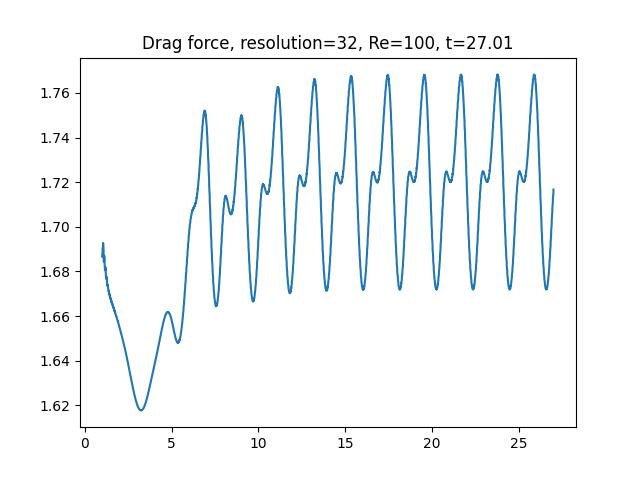

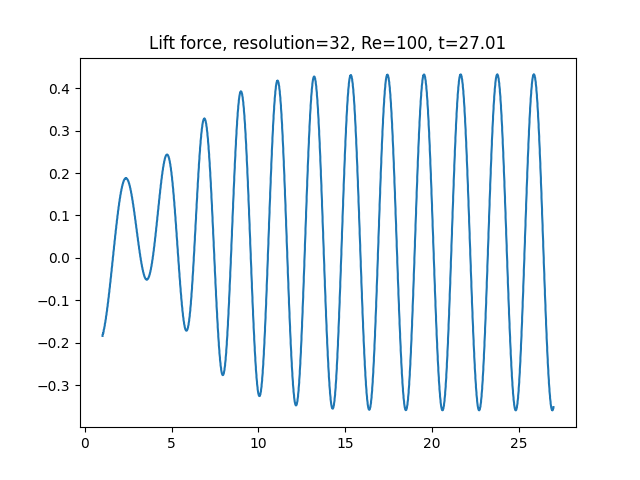

We finally increase the Reynolds number to $Re=1000$, which again results in an unstable flow with a Karman vortex street. We find that $c_D = 7.842\pm0.349$ and $c_L = 0.276\pm2.252$. We estimate that $f=0.5$, yielding $St=0.2$, just as before.

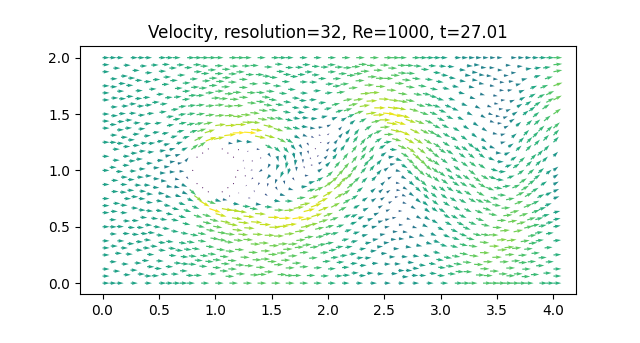

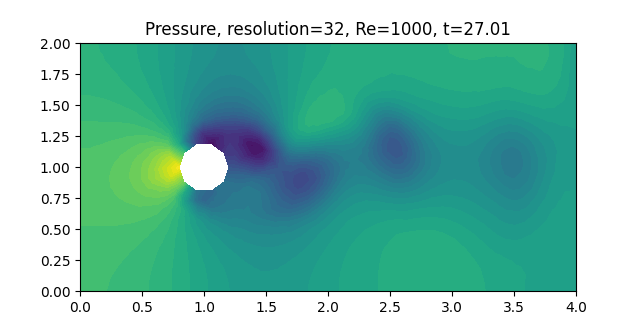

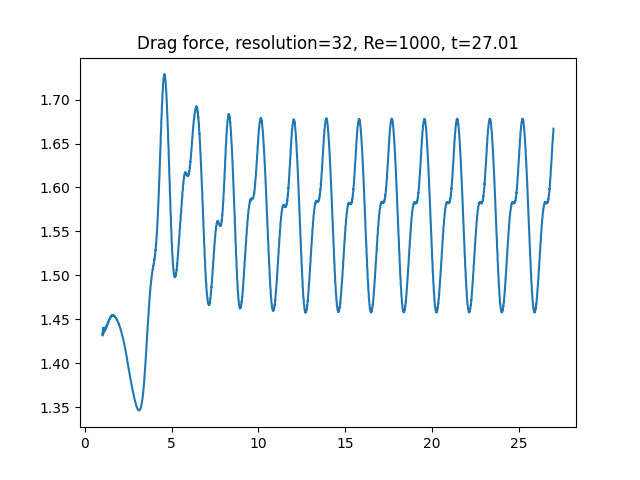

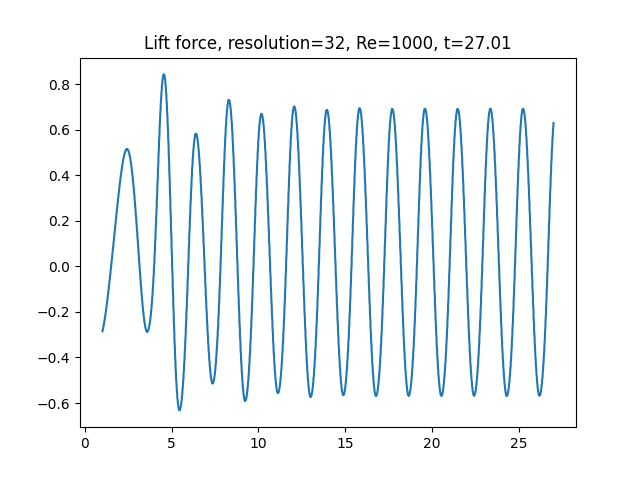

**The effect of decreasing the mesh resolution**

The preceding solutions were computed using a constant mesh resolution and varying Reynolds numbers. Now, we reverse our approach and fix the Reynolds number at $Re=100$, but examine the effects of different mesh resolutions.


With $h=1/16$, we obtain the plots below. The circular geometry of the hole is not very well-preserved, but apart from that, the solution appears similar to the solution for $h=1/32$. We can still observe vortex shedding, and the forces continue to oscillate. However, the initial irregularities persist for a much longer time. We determine that $c_D = 10.453\pm0.032$ and $c_L = -0.051\pm0.770$. We estimate that $f=0.4$, giving $St=0.16$, i.e., slightly lower than before.

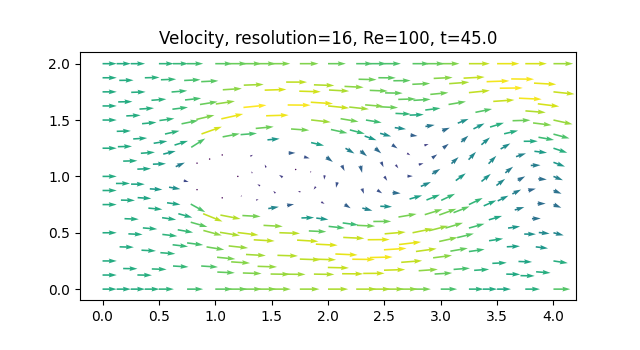

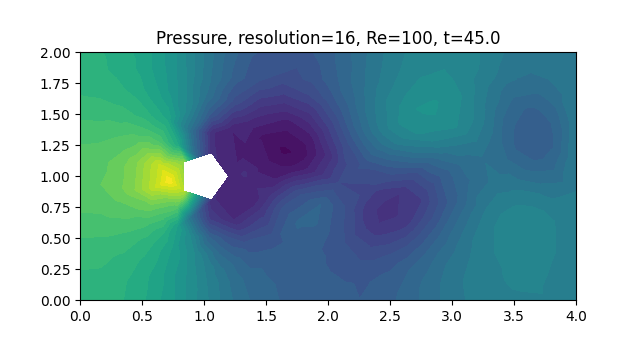

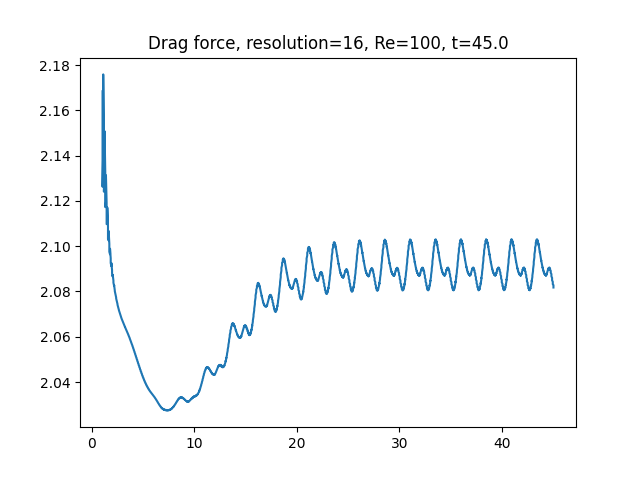

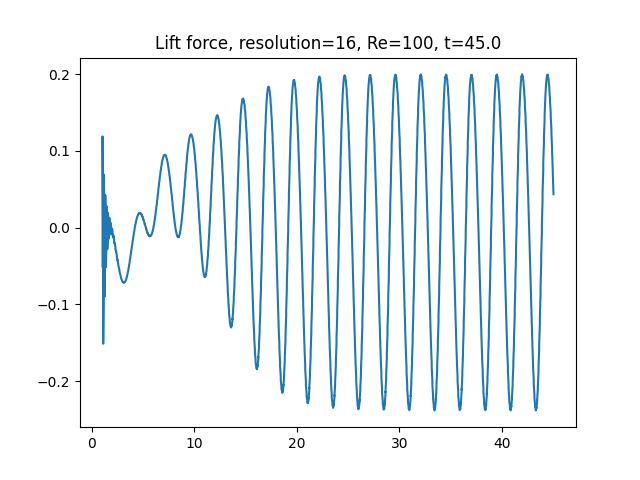

With $h=1/8$, the mesh is no longer fine enough to properly resolve the effects of the cylinder on the pressure and velocity fields. The Karman vortex street has disappeared, causing the flow to appear stable, with the force eventually stabilizing around a constant value. However, both the velocity and pressure fields lack symmetry. We now have $c_D = 14.948$ and $c_L = -0.294$.

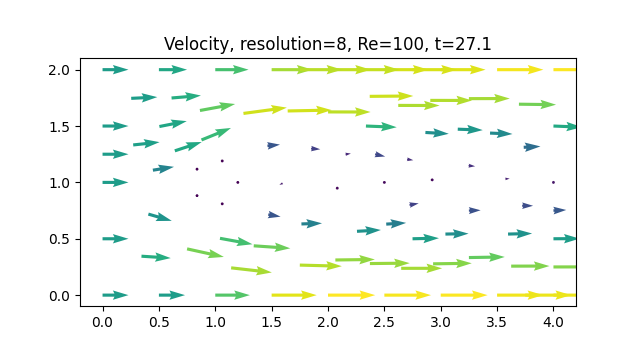

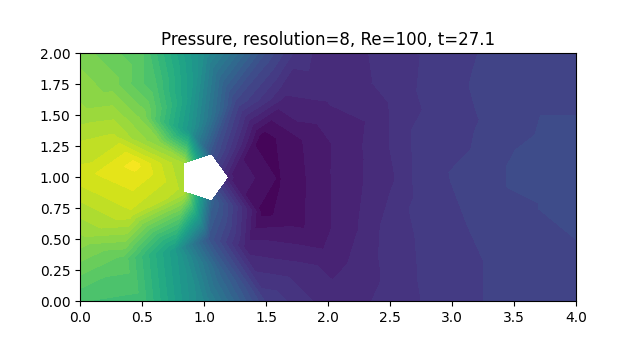

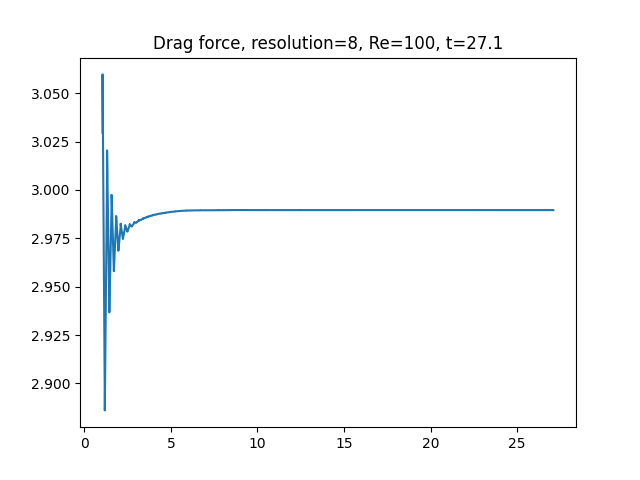

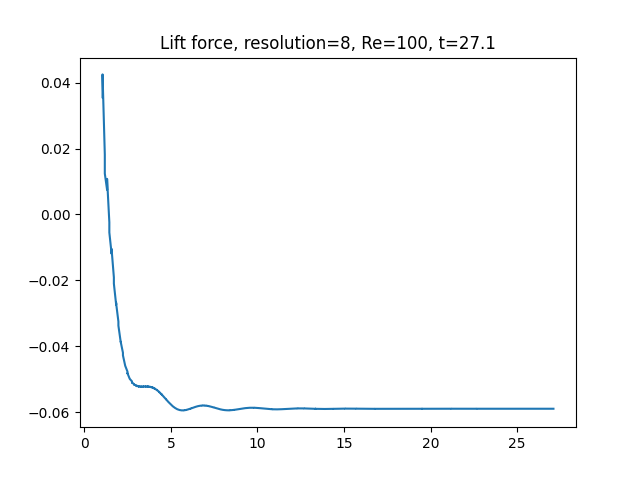

**Animations of the solution**

Paraview animations of the solution for $Re=100$ and $h=1/32$ can be found here: [velocity movie](https://drive.google.com/file/d/1z-rkzjhOv6lsTPbZMVIn0E5hWE3ktCdf/view?usp=drive_link) and [pressure movie](https://drive.google.com/file/d/1X425LX5vYc-N1MYn5KTHSBgT_AovzwFL/view?usp=drive_link).


# **Discussion**

A stabilized finite element method was implemented in FEniCS to solve the Navier-Stokes equations in 2D. The method was tested for the model problem of flow past a circular obstacle of radius 0.2. For a small Reynolds number ($Re=1, 10$), the flow remained stable, while for a high Reynolds number ($Re=100, 1000$), a Karman vortex street developed. With a mesh resolution of $h=1/32$, the mean drag coefficient was found to decrease with an increased Reynolds number, from 88.6 down to 7.8. In contrast, the lift coefficient underwent successively greater oscillations, with values ranging from $0.19\pm0.00$ to $0.28\pm2.25$. Moreover, the Strouhal number was estimated to 0.2. Simulations were also conducted using coarser mesh resolutions of $h=1/16$ and $h=1/8$, both giving less accurate solutions. In particular, with $h=1/8$ it was not possible to resolve the Karman vortex street at all.